In [ ]:
import kagglehub
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
import IPython.display
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


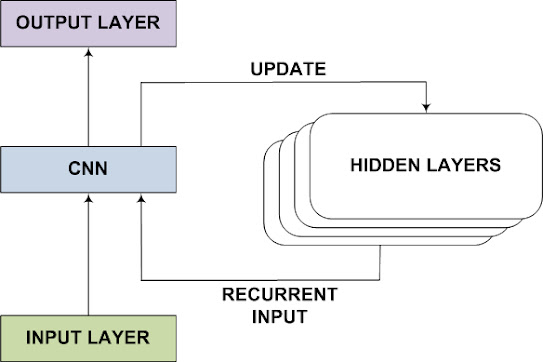

### 1. 데이터셋 가져오기

1. Kagglehub를 사용하여 Bird Voice Detection 데이터셋의 최신 버전을 다운로드합니다.



In [ ]:
# Download latest version
path = kagglehub.dataset_download("vshantam/bird-voice-detection")

print("Path to dataset files:", path)

100%|██████████| 5.51G/5.51G [01:02<00:00, 94.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1


2. 다운로드한 데이터셋의 최상위 경로를 설정하고, 오디오 파일 경로 및 메타데이터 파일 경로를 지정합니다. 이후 pandas를 사용해 메타데이터를 불러옵니다.

In [ ]:
# 다운받은 데이터셋의 최상위 경로
dataset_path = Path("/root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1")

audio_path = dataset_path / "ff1010bird_wav" / "wav"

metadata_fp = dataset_path / "metadata.csv"

print("Audio files location:", audio_path)
print("Metadata file path:", metadata_fp)

Audio files location: /root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1/ff1010bird_wav/wav
Metadata file path: /root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1/metadata.csv


In [ ]:
# 메타데이터 파일 읽기
metadata = pd.read_csv(metadata_fp)
metadata.head()

id  label
0   64486      0
1    2525      0
2   44981      0
3  101323      0
4  165746      0

3. 지정된 오디오 파일 디렉토리 내의 wav 파일 목록을 확인한 후, 첫 번째 파일을 선택해 파형을 시각화하고 오디오 플레이어를 통해 직접 들어봅니다.

In [ ]:
# wav 파일 목록 가져오기
audio_files = list(audio_path.glob("*.wav"))
print(f"Found {len(audio_files)} audio files.")

# 첫 5개 파일 이름 출력
print("\nExample file names:")
for f in audio_files[:5]:
    print(f.name)

Found 7690 audio files.

Example file names:
38392.wav
20714.wav
127511.wav
77748.wav
93756.wav


Audio shape: (220500,), Sample rate: 22050


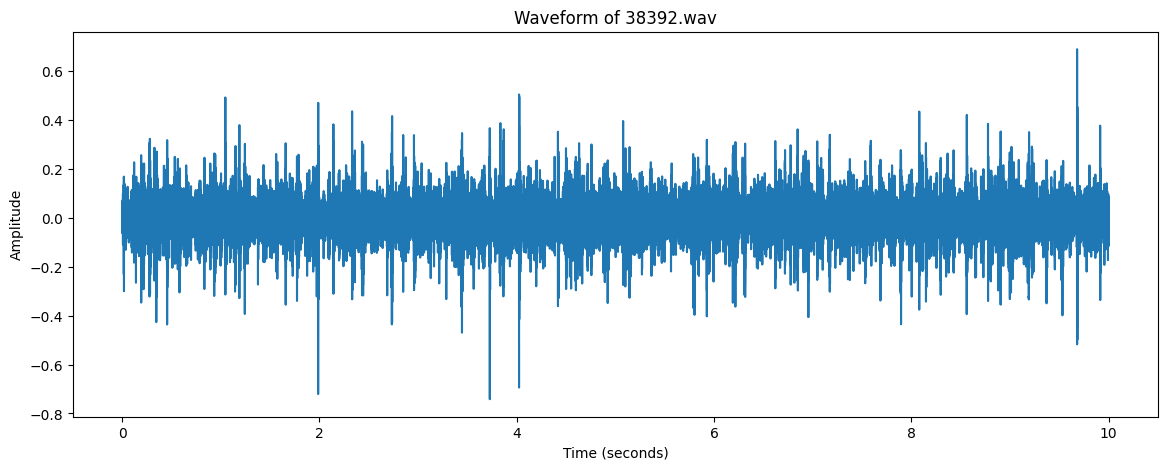

In [ ]:
# 첫 번째 오디오 파일 선택
example_file = audio_files[0]

# 오디오 파일 로드 (sample rate: 22050Hz)
y, sr = librosa.load(example_file, sr=22050)
print(f"Audio shape: {y.shape}, Sample rate: {sr}")

# 시간축 생성
time = np.linspace(0, len(y) / sr, num=len(y))

# 파형 시각화
plt.figure(figsize=(14, 5))
plt.plot(time, y)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Waveform of {example_file.name}")
plt.show()


In [ ]:
# 선택한 오디오 파일 재생
Audio(filename=str(example_file))

4. 오디오 파일을 로드하고, pre-emphasis, log mel spectrogram, 그리고 MFCC와 같은 오디오 특징을 추출하는 함수를 정의합니다.

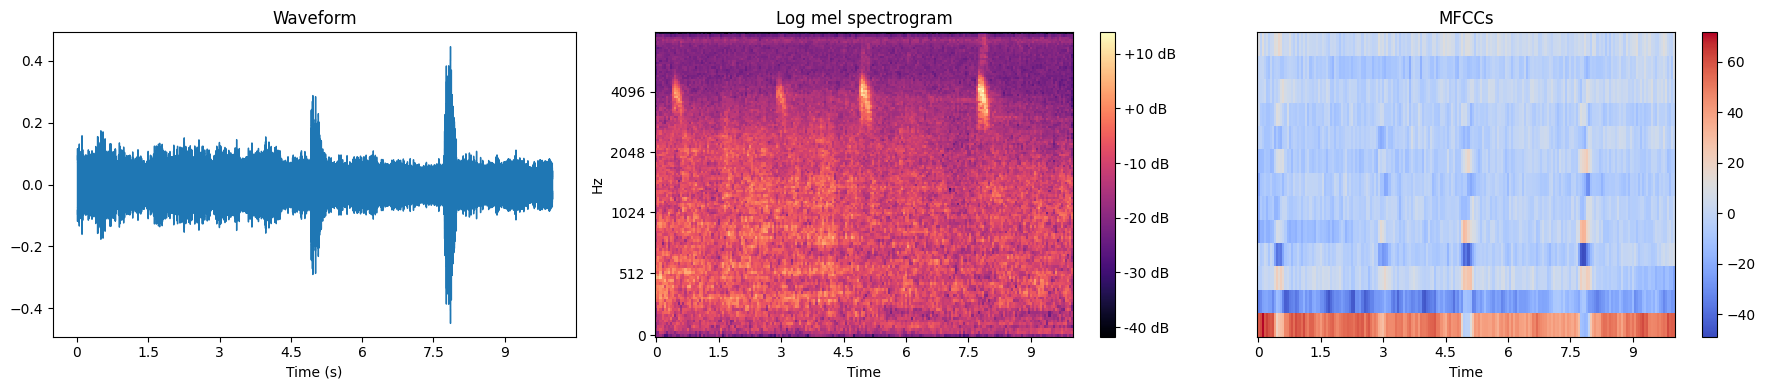

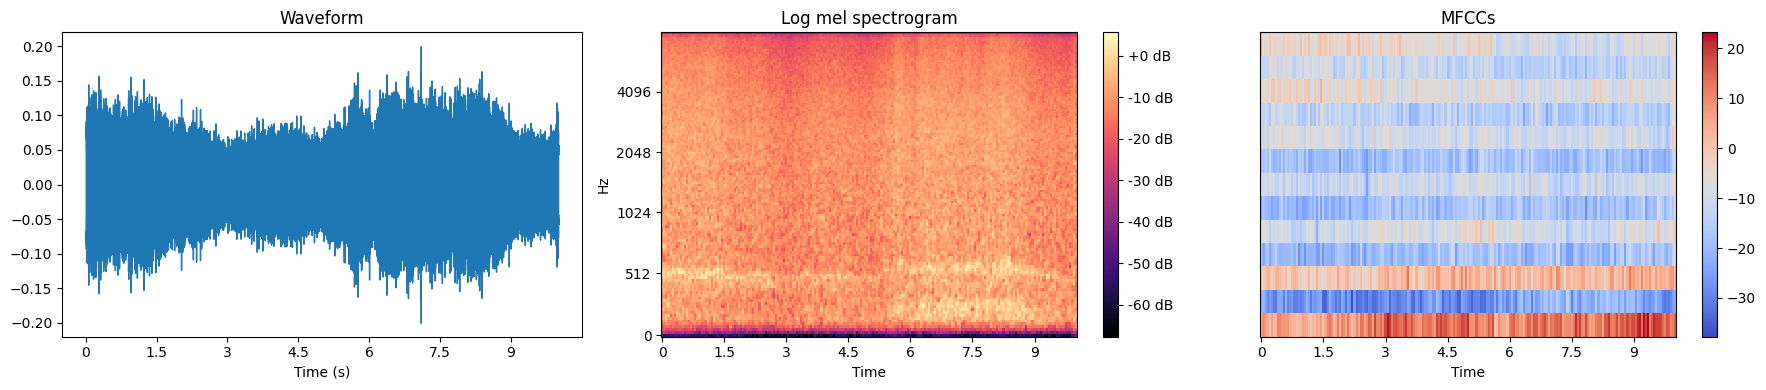

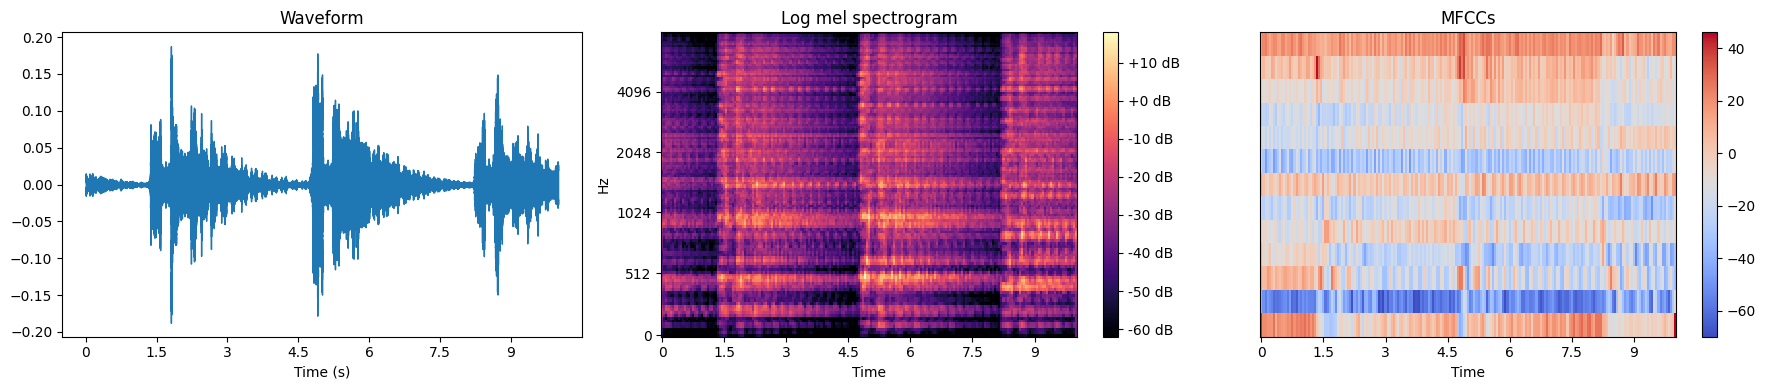

In [ ]:
def load_audio(fp: Path, sampling_rate: int = 16000, preemphasis: bool = True):
    # 오디오 로드 및 리샘플링
    audio, sr = librosa.load(fp, sr=sampling_rate)

    # pre-emphasis 적용 (고역 강조)
    if preemphasis:
        audio = librosa.effects.preemphasis(audio)
    return audio, sr

def generate_log_mel_spectrogram(audio, sampling_rate: int = 16000, window_length: float = 100, hop_length: float = 50):
    # window_length와 hop_length를 밀리초 단위에서 샘플 단위로 변환
    win_length = int(window_length * sampling_rate * 1e-3)
    hop_length = int(hop_length * sampling_rate * 1e-3)

    # mel-spectrogram 생성 (STFT 후 mel 필터 뱅크 적용)
    ms = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, win_length=win_length, hop_length=hop_length)
    # 전력 스펙트럼을 dB 스케일로 변환
    log_ms = librosa.power_to_db(S=ms)
    return log_ms, win_length, hop_length

def generate_MFCC(log_ms, n_mfcc: int = 20):
    # log mel-spectrogram으로부터 MFCC 계산, 보통 첫 13개의 계수를 사용
    mfcc = librosa.feature.mfcc(S=log_ms, n_mfcc=n_mfcc)
    mfcc = mfcc[1:14]  # 인덱스 1부터 13까지 사용
    return mfcc

def visualize_audio(fp: Path):
    """주어진 오디오 파일의 Waveform, Log mel spectrogram, MFCCs를 시각화하고 오디오 플레이어를 표시합니다."""

    # IPython을 이용한 오디오 재생 (Notebook 환경에서)
    IPython.display.display(IPython.display.Audio(filename=str(fp)))

    # 오디오 로드 및 전처리
    audio, sr = load_audio(fp)

    # log mel spectrogram과 MFCC 계산
    log_ms, win_length, hop_length = generate_log_mel_spectrogram(audio, sampling_rate=sr)
    mfcc = generate_MFCC(log_ms)

    # matplotlib를 이용한 시각화 (1행 3열 서브플롯)
    plt.figure(figsize=(18, 4))

    # 1. Waveform
    plt.subplot(1, 3, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.xlabel("Time (s)")
    plt.title("Waveform")

    # 2. Log mel spectrogram
    plt.subplot(1, 3, 2)
    librosa.display.specshow(log_ms, sr=sr, hop_length=hop_length, win_length=win_length, x_axis='time', y_axis='mel')
    plt.title("Log mel spectrogram")
    plt.colorbar(format='%+2.0f dB')

    # 3. MFCCs
    plt.subplot(1, 3, 3)
    librosa.display.specshow(mfcc, sr=sr, hop_length=hop_length, x_axis='time')
    plt.title("MFCCs")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# 예시 사용: 특정 오디오 파일 경로를 지정해 시각화 실행
audio_file_path = "/root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1/ff1010bird_wav/wav/"
visualize_audio(Path(audio_file_path+"55111.wav"))
visualize_audio(Path(audio_file_path+"147599.wav"))
visualize_audio(Path(audio_file_path+"181606.wav"))

### 2. CRNN 모델을 위한 데이터 준비 및 학습

1. 메타데이터를 사용하여 데이터셋을 train/test로 나누고, 오디오 파일에서 log mel spectrogram을 추출해 CRNN 모델 학습에 맞게 데이터를 전처리합니다. 이후, tf.data.Dataset을 활용하여 모델을 학습시킵니다.

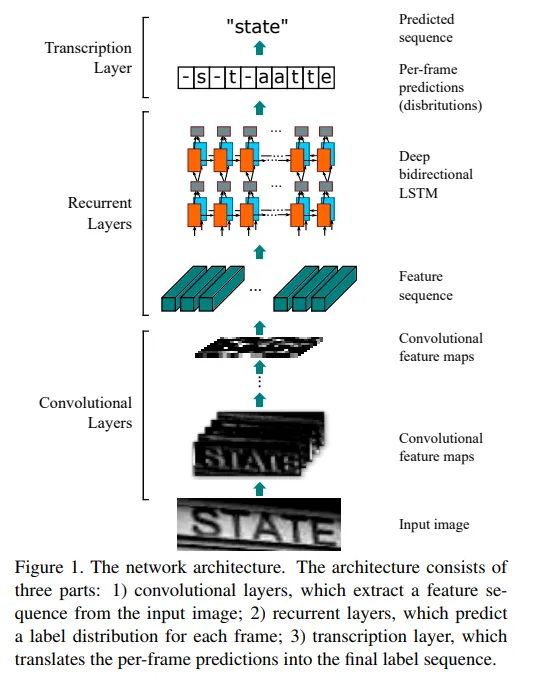

1. CNN을 통해 input 이미지로부터 feature sequence를 추출한다.
2. 추출한 feature sequence들을 RNN의 input으로 하여 이미지의 텍스트 시퀀스를 예측한다.
3. 예측된 텍스트 시퀀스를 텍스트로 변환한다.

In [ ]:
# train/test split (예: stratify 옵션으로 클래스 불균형을 보완)
train_df, test_df = train_test_split(metadata, test_size=0.2, random_state=42, stratify=metadata['label'])
print("학습 샘플 수:", len(train_df), "테스트 샘플 수:", len(test_df))

학습 샘플 수: 6152 테스트 샘플 수: 1538


In [ ]:
def get_audio_path(sample_id):
    """
    sample_id에 해당하는 파일 경로를 반환합니다.
    id 컬럼이 파일 이름(예: "55111.wav")에 대응한다고 가정합니다.
    """
    return audio_file_path + f"{sample_id}.wav"

In [ ]:
# 3. 오디오 전처리 및 특징 추출 함수
def load_audio(fp: Path, sampling_rate: int = 16000, preemphasis: bool = True):
    # 오디오 로드 및 리샘플링
    audio, sr = librosa.load(fp, sr=sampling_rate)
    # pre-emphasis 적용 (고역 강조)
    if preemphasis:
        audio = librosa.effects.preemphasis(audio)
    return audio, sr

def generate_log_mel_spectrogram(audio, sampling_rate: int = 16000, window_length: float = 100, hop_length: float = 50):
    # window_length와 hop_length를 밀리초 단위에서 샘플 단위로 변환
    win_length = int(window_length * sampling_rate * 1e-3)
    hop_length = int(hop_length * sampling_rate * 1e-3)
    # mel-spectrogram 생성 (STFT 후 mel 필터 뱅크 적용)
    ms = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, win_length=win_length, hop_length=hop_length, n_mels=128)
    # 전력 스펙트럼을 dB 스케일로 변환
    log_ms = librosa.power_to_db(S=ms)
    return log_ms  # shape: (n_mels, t)

def extract_features(sample_id, sampling_rate: int = 16000):
    """주어진 sample_id에 대해 log mel spectrogram을 추출하고 CRNN 입력에 맞게 reshape 합니다."""
    fp = get_audio_path(sample_id)
    audio, sr = load_audio(fp, sampling_rate=sampling_rate)
    log_ms = generate_log_mel_spectrogram(audio, sampling_rate=sr)
    # log_ms shape: (n_mels, t). CRNN 모델 입력으로 사용하려면 channel 차원 추가하고
    # 일반적으로 time dimension을 first axis로 사용하므로, (t, n_mels, 1) 형태로 변환합니다.
    log_ms = log_ms.T  # now shape: (t, n_mels)
    log_ms = np.expand_dims(log_ms, axis=-1)  # (t, n_mels, 1)
    return log_ms

In [ ]:
# 4. 데이터 제너레이터 (tf.data 사용)
def data_generator(df, batch_size=16, sampling_rate=16000):
    """주어진 DataFrame(df)에서 배치 단위로 log mel spectrogram과 레이블 반환"""
    sample_ids = df['id'].values
    labels = df['label'].values

    # 무한 반복하는 제너레이터
    def gen():
        indices = np.arange(len(sample_ids))
        np.random.shuffle(indices)
        for i in indices:
            sample_id = sample_ids[i]
            label = labels[i]
            features = extract_features(sample_id, sampling_rate)
            yield features, label

    # 오디오 길이가 다를 수 있으므로 padding 처리 필요.
    # 여기서는 tf.data.experimental.dense_to_ragged_batch을 활용하거나,
    # 사용자 정의 padding 함수를 적용할 수 있습니다.
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    ds = ds.padded_batch(batch_size, padded_shapes=([None, 128, 1], []))
    return ds


In [ ]:
# 5. CRNN 모델 구성
def build_crnn_model(input_shape, num_classes=1):
    """
    CRNN 모델 구성.
    input_shape: (t, n_mels, 1), t는 time steps (None, 가변 길이)
    num_classes: 이진 분류이면 1 (sigmoid), 다중 분류이면 클래스 수와 softmax 사용.
    """
    inp = Input(shape=input_shape)

    # Convolutional layers: 2D convolution over spectrogram
    x = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    # x의 shape: (batch, t', n_mels', channels)
    # 정적 shape 정보를 사용하여 새로운 feature dimension을 계산합니다.
    shape = tf.keras.backend.int_shape(x)  # tuple: (batch, t', n_mels', channels)
    new_feature_dim = shape[2] * shape[3]    # n_mels' * channels
    # Reshape: time dimension은 그대로 두고 feature 차원으로 병합합니다.
    x = Reshape((-1, new_feature_dim))(x)

    # Recurrent layer (양방향 LSTM)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    # 분류를 위한 Dense layer
    if num_classes == 1:
        out = Dense(1, activation='sigmoid')(x)
    else:
        out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    return model

In [ ]:
# 6. 모델 학습 준비 및 실행
# 먼저, 예시로 하나의 배치에서 입력 feature의 shape를 확인해봅니다.
# (데이터마다 길이가 다르므로, 가장 긴 길이에 맞춰 padding됩니다.)
sample_features = extract_features(train_df.iloc[0]['id'])
print("Sample feature shape:", sample_features.shape)  # 예: (time, 128, 1)

Sample feature shape: (201, 128, 1)


In [ ]:
input_shape = (None, 128, 1)
model = build_crnn_model(input_shape, num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 128, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, 128, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 128, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, None, 64, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, 64, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 64, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, None, 32, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │         557,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562,689 (2.15 MB)

 Trainable params: 562,593 (2.15 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
# tf.data.Dataset으로 제너레이터 생성 (예: 배치 크기 16)
train_ds = data_generator(train_df, batch_size=32)
test_ds = data_generator(test_df, batch_size=32)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


# 모델 학습 (에포크 수와 steps_per_epoch 등은 데이터 크기에 따라 조정)
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
    193/Unknown 173s 851ms/step - accuracy: 0.7699 - loss: 0.5144

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7700 - loss: 0.5143 - val_accuracy: 0.8108 - val_loss: 0.4485
Epoch 2/3
193/193 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.8193 - loss: 0.4353 - val_accuracy: 0.8212 - val_loss: 0.4308
Epoch 3/3
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8317 - loss: 0.4145 - val_accuracy: 0.8257 - val_loss: 0.4255


### 3. 모델 평가 및 결과 시각화

1. 학습이 완료된 모델을 사용하여 테스트 데이터를 평가하고, 혼동 행렬 및 학습 이력(손실, 정확도)을 시각화합니다.

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8084 - loss: 0.4424
Test Loss: 0.4254609942436218
Test Accuracy: 0.8257477283477783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

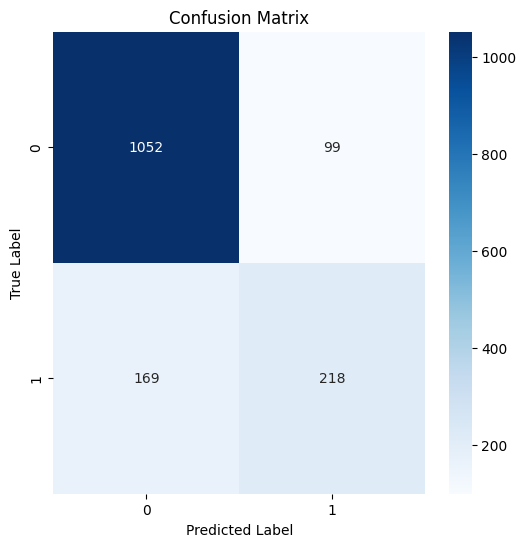

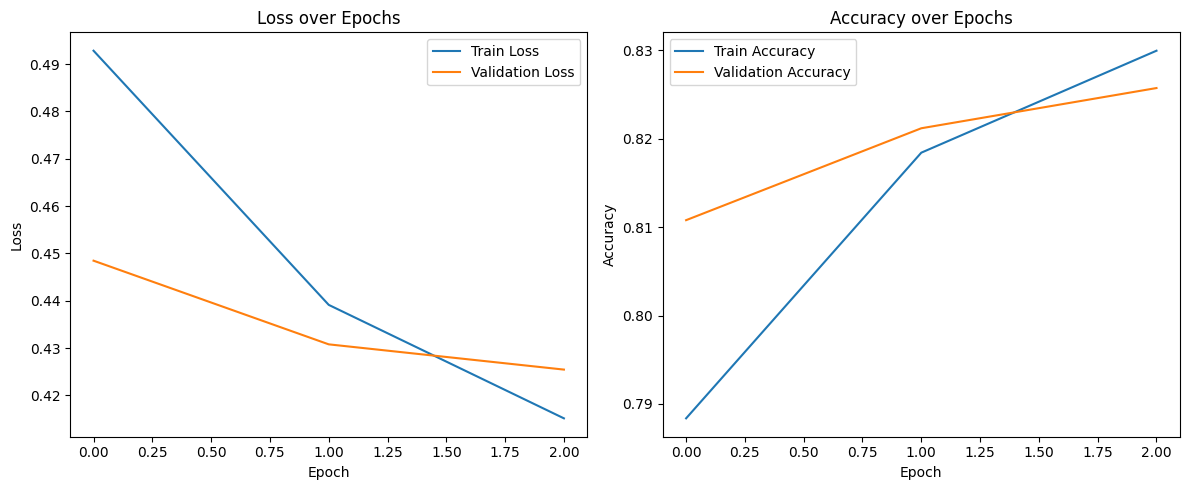

In [ ]:
# 1. 테스트 세트 평가
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# 2. 테스트 세트에 대한 예측 수행 및 결과 저장
y_true = []
y_pred = []
for features, labels in test_ds:
    preds = model.predict(features)
    # 이진 분류일 경우, 0.5 임계값을 기준으로 분류
    preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

# 분류 리포트 출력
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 3. 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 4. 학습 이력(History) 시각화 (손실 및 정확도 곡선)
plt.figure(figsize=(12,5))

# 손실 곡선
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# 정확도 곡선
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


### 4. 테스트 샘플 개별 시각화 및 예측

1. 특정 테스트 오디오 파일(예: "181606.wav")을 시각화한 후, 학습된 모델로 예측하여 결과를 출력합니다.

Found 7690 audio files.
Randomly selected file: 144941.wav


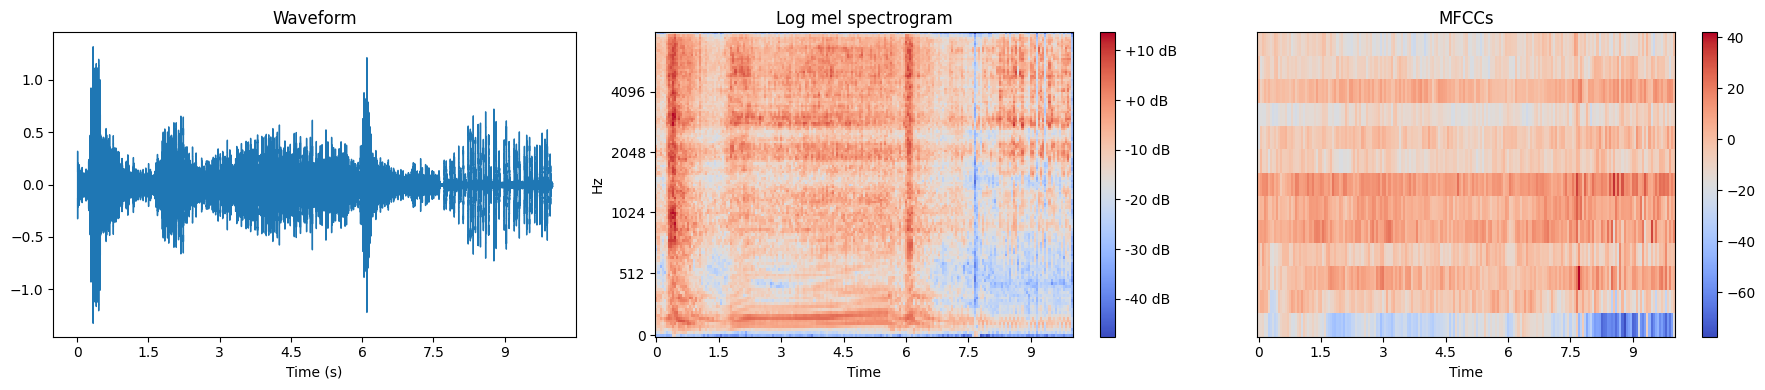

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted label for 144941.wav: 0 (Probability: 0.4167)


In [ ]:
def generate_log_mel_spectrogram(audio, sampling_rate: int = 16000, window_length: float = 100, hop_length: float = 50):
    win_length = int(window_length * sampling_rate * 1e-3)
    hop_length = int(hop_length * sampling_rate * 1e-3)
    ms = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, win_length=win_length, hop_length=hop_length)
    log_ms = librosa.power_to_db(S=ms)
    return log_ms, win_length, hop_length

def extract_features_from_fp(fp: Path, sampling_rate: int = 16000):
    """
    주어진 파일 경로(fp)에서 오디오를 로드하고, log mel spectrogram을 추출하여
    CRNN 모델의 입력 형태 (time, n_mels, 1)로 변환합니다.
    """
    # 오디오 로드
    audio, sr = load_audio(fp, sampling_rate=sampling_rate)
    # log mel spectrogram 생성 (반환값을 언팩)
    log_ms, win_length, hop_length = generate_log_mel_spectrogram(audio, sampling_rate=sr)
    # 전치(transpose): (n_mels, t) -> (t, n_mels)
    log_ms = log_ms.T
    # 채널 차원 추가: (t, n_mels) -> (t, n_mels, 1)
    log_ms = np.expand_dims(log_ms, axis=-1)
    return log_ms

def predict_and_visualize(fp: Path, model):
    """
    주어진 오디오 파일 경로(fp)에 대해:
      1. visualize_audio() 함수를 이용해 오디오 데이터를 시각화하고,
      2. extract_features_from_fp()로 특징을 추출한 후, 모델 예측을 수행하여 결과를 출력합니다.
    """
    # 시각화
    visualize_audio(fp)

    # 특징 추출
    features = extract_features_from_fp(fp)
    # 모델 입력으로 사용하기 위해 배치 차원 추가
    features_expanded = np.expand_dims(features, axis=0)

    # 모델 예측
    pred = model.predict(features_expanded)

    # 이진 분류라고 가정 (임계값 0.5)
    pred_label = (pred > 0.5).astype(int)[0][0]
    print(f"Predicted label for {fp.name}: {pred_label} (Probability: {pred[0][0]:.4f})")

audio_dir = Path("/root/.cache/kagglehub/datasets/vshantam/bird-voice-detection/versions/1/ff1010bird_wav/wav")
audio_files = list(audio_dir.glob("*.wav"))
print(f"Found {len(audio_files)} audio files.")

# 랜덤 오디오 파일 선택
random_audio_fp = random.choice(audio_files)
print("Randomly selected file:", random_audio_fp.name)

# 시각화 및 예측 수행
predict_and_visualize(random_audio_fp, model)